# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
# separable means that each convolution is happening only on one layer at a time.
# the output "depth" is happenning thanks to 1x1 convolution at the output
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

# 1x1 followed by batch normalization
# Stride has to be set to 1
def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # Concatenate the upsampled and large input layers using layers.concatenate
    concat = layers.concatenate([upsampled, large_ip_layer])
    
    # Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concat, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    # The shrinking of the layers ia achieved by changing stride
    # We also use more depth as illustrated by 32 and then 64
    # Initially I had 16 and 32 and the higher values perform much better without incurring too much of a cost
    l1 = encoder_block(inputs, 32, 2)
    l2 = encoder_block(l1, 64, 2)

    # Add 1x1 Convolution layer using conv2d_batchnorm().
    # This is implemented as regular convo so set stride and kernel to 1 for it to be 1x1
    l3 = conv2d_batchnorm(l2, 64, kernel_size=1, strides=1)
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    # Add decoder blocks and the skip layer connections
    # If you look at the implementation of the decoder the elementwise addition is happening
    # after the upsample. So we have to connect the layers of correct size.
    l4 = decoder_block(l3, l1, 64)
    l5 = decoder_block(l4, inputs, 32)
    
    x = l5
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
# Started with 0.1 and lowered gradually
learning_rate = 0.001
# Batch size is number of pictures per "iteration". Interplays with steps_per_epoch
# Ideally the network should see each picture during epoch
batch_size = 30
# picked 80 since it filled the night seems like the network is still learning
num_epochs = 80
steps_per_epoch = 200
validation_steps = 50
# did not tweak this value. Probably should be equal to number of cores
workers = 2

Epoch 1/80
199/200 [============================>.] - ETA: 4s - loss: 0.3595

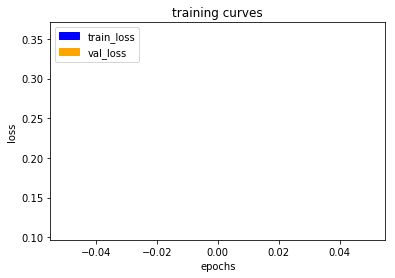

200/200 [==============================] - 855s - loss: 0.3579 - val_loss: 0.1093
Epoch 2/80
199/200 [============================>.] - ETA: 4s - loss: 0.0556

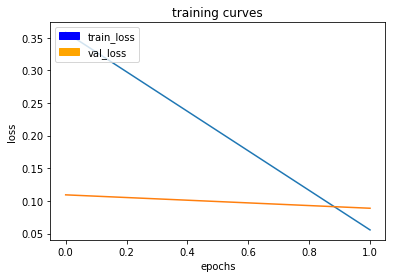

200/200 [==============================] - 902s - loss: 0.0556 - val_loss: 0.0888
Epoch 3/80
199/200 [============================>.] - ETA: 3s - loss: 0.0494

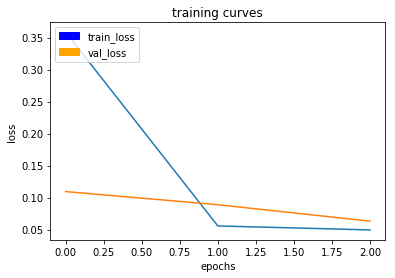

200/200 [==============================] - 850s - loss: 0.0493 - val_loss: 0.0631
Epoch 4/80
199/200 [============================>.] - ETA: 3s - loss: 0.0462

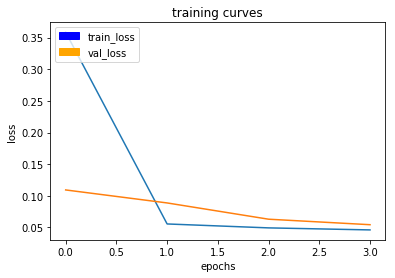

200/200 [==============================] - 849s - loss: 0.0461 - val_loss: 0.0544
Epoch 5/80
199/200 [============================>.] - ETA: 3s - loss: 0.0437

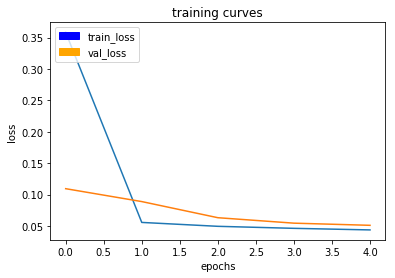

200/200 [==============================] - 847s - loss: 0.0436 - val_loss: 0.0510
Epoch 6/80
199/200 [============================>.] - ETA: 3s - loss: 0.0412

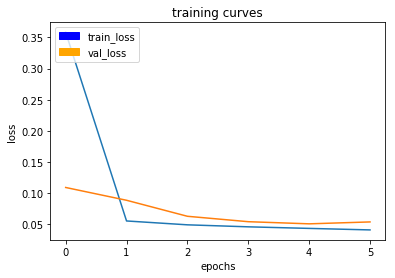

200/200 [==============================] - 849s - loss: 0.0412 - val_loss: 0.0540
Epoch 7/80
199/200 [============================>.] - ETA: 3s - loss: 0.0401

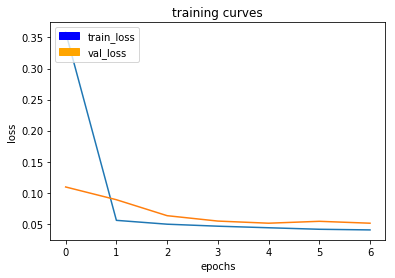

200/200 [==============================] - 848s - loss: 0.0402 - val_loss: 0.0509
Epoch 8/80
199/200 [============================>.] - ETA: 3s - loss: 0.0398

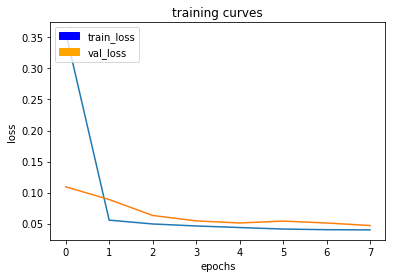

200/200 [==============================] - 848s - loss: 0.0398 - val_loss: 0.0469
Epoch 9/80
199/200 [============================>.] - ETA: 3s - loss: 0.0374

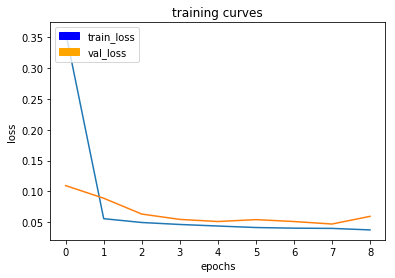

200/200 [==============================] - 850s - loss: 0.0374 - val_loss: 0.0593
Epoch 10/80
199/200 [============================>.] - ETA: 3s - loss: 0.0367

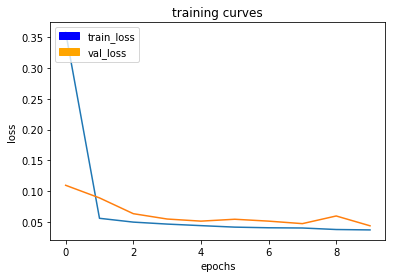

200/200 [==============================] - 852s - loss: 0.0366 - val_loss: 0.0433
Epoch 11/80
199/200 [============================>.] - ETA: 3s - loss: 0.0363

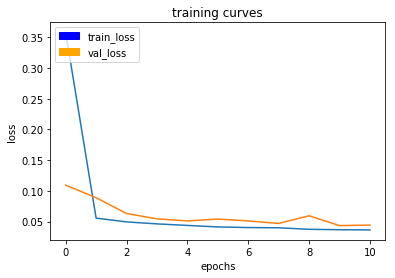

200/200 [==============================] - 848s - loss: 0.0363 - val_loss: 0.0442
Epoch 12/80
199/200 [============================>.] - ETA: 3s - loss: 0.0357

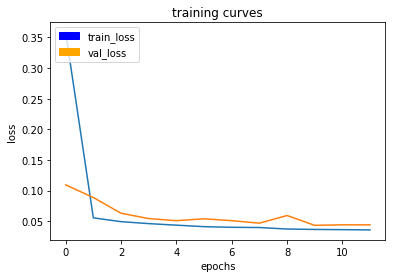

200/200 [==============================] - 847s - loss: 0.0359 - val_loss: 0.0441
Epoch 13/80
199/200 [============================>.] - ETA: 3s - loss: 0.0345

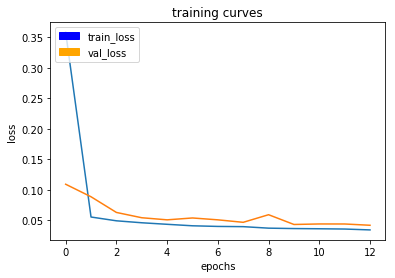

200/200 [==============================] - 849s - loss: 0.0344 - val_loss: 0.0420
Epoch 14/80
199/200 [============================>.] - ETA: 3s - loss: 0.0329

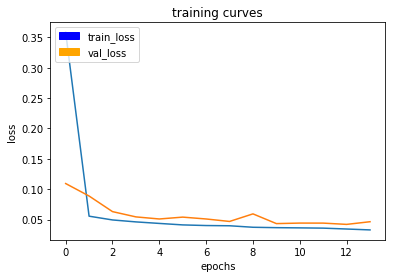

200/200 [==============================] - 848s - loss: 0.0329 - val_loss: 0.0464
Epoch 15/80
199/200 [============================>.] - ETA: 3s - loss: 0.0337

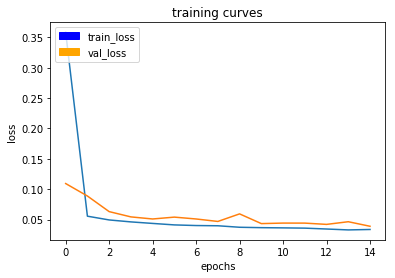

200/200 [==============================] - 850s - loss: 0.0337 - val_loss: 0.0389
Epoch 16/80
199/200 [============================>.] - ETA: 3s - loss: 0.0327

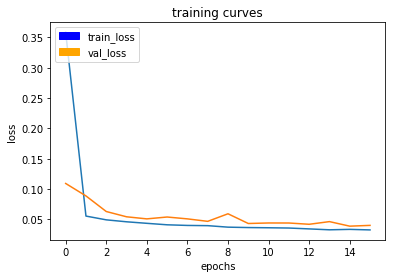

200/200 [==============================] - 850s - loss: 0.0327 - val_loss: 0.0402
Epoch 17/80
199/200 [============================>.] - ETA: 3s - loss: 0.0327

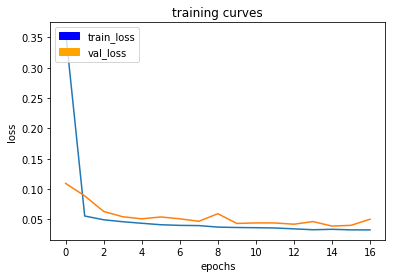

200/200 [==============================] - 851s - loss: 0.0326 - val_loss: 0.0503
Epoch 18/80
199/200 [============================>.] - ETA: 3s - loss: 0.0306

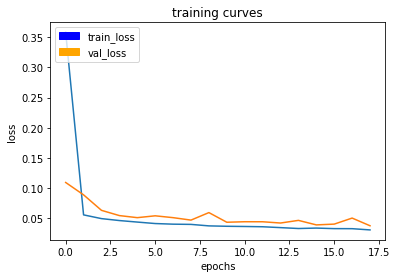

200/200 [==============================] - 850s - loss: 0.0306 - val_loss: 0.0375
Epoch 19/80
199/200 [============================>.] - ETA: 3s - loss: 0.0316

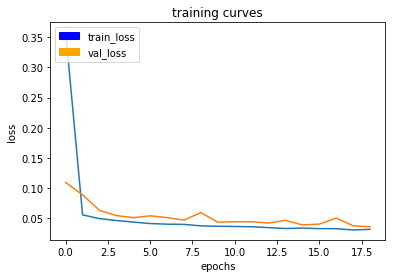

200/200 [==============================] - 852s - loss: 0.0316 - val_loss: 0.0357
Epoch 20/80
199/200 [============================>.] - ETA: 3s - loss: 0.0305

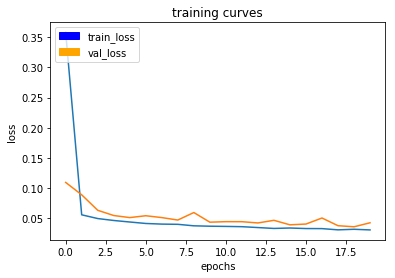

200/200 [==============================] - 852s - loss: 0.0305 - val_loss: 0.0423
Epoch 21/80
199/200 [============================>.] - ETA: 3s - loss: 0.0314

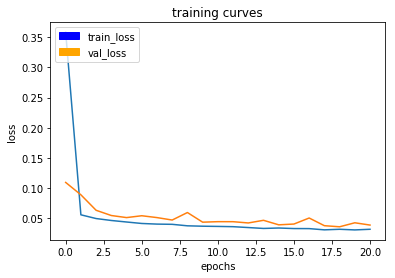

200/200 [==============================] - 850s - loss: 0.0316 - val_loss: 0.0385
Epoch 22/80
199/200 [============================>.] - ETA: 3s - loss: 0.0289

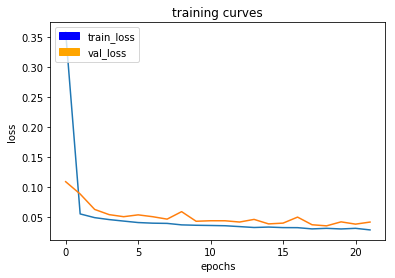

200/200 [==============================] - 851s - loss: 0.0289 - val_loss: 0.0420
Epoch 23/80
199/200 [============================>.] - ETA: 3s - loss: 0.0313

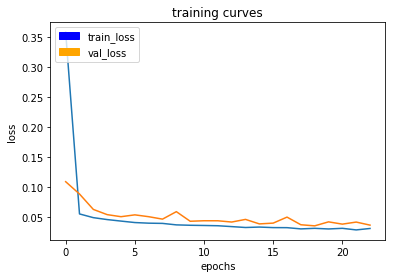

200/200 [==============================] - 849s - loss: 0.0313 - val_loss: 0.0369
Epoch 24/80
199/200 [============================>.] - ETA: 3s - loss: 0.0284

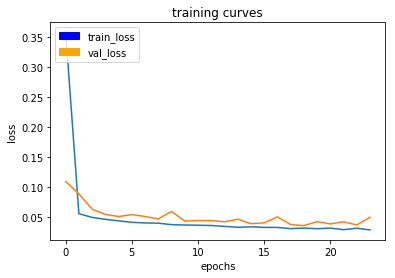

200/200 [==============================] - 852s - loss: 0.0285 - val_loss: 0.0495
Epoch 25/80
199/200 [============================>.] - ETA: 3s - loss: 0.0299

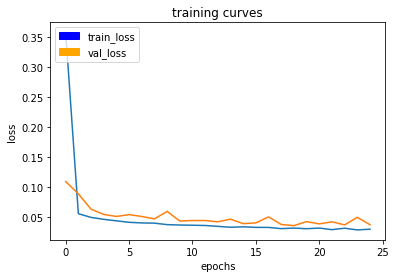

200/200 [==============================] - 852s - loss: 0.0299 - val_loss: 0.0371
Epoch 26/80
199/200 [============================>.] - ETA: 3s - loss: 0.0289

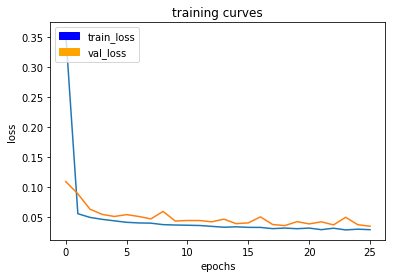

200/200 [==============================] - 852s - loss: 0.0289 - val_loss: 0.0347
Epoch 27/80
199/200 [============================>.] - ETA: 3s - loss: 0.0292

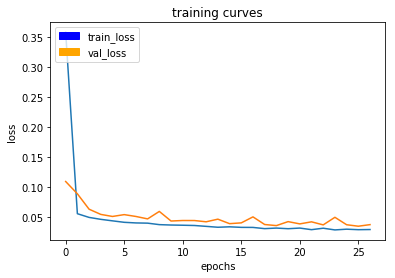

200/200 [==============================] - 848s - loss: 0.0291 - val_loss: 0.0373
Epoch 28/80
199/200 [============================>.] - ETA: 3s - loss: 0.0282

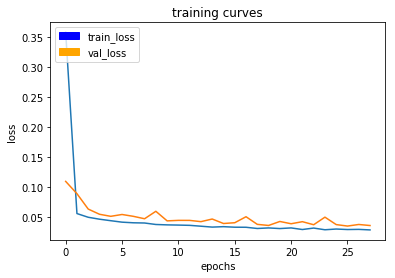

200/200 [==============================] - 850s - loss: 0.0282 - val_loss: 0.0356
Epoch 29/80
199/200 [============================>.] - ETA: 3s - loss: 0.0286

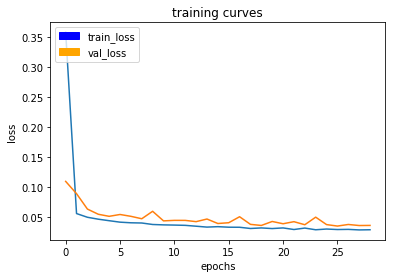

200/200 [==============================] - 849s - loss: 0.0286 - val_loss: 0.0357
Epoch 30/80
199/200 [============================>.] - ETA: 3s - loss: 0.0276

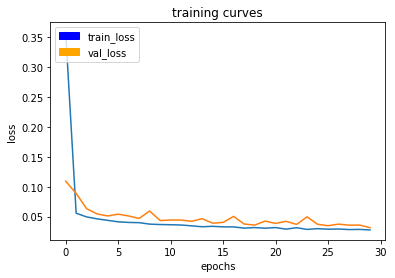

200/200 [==============================] - 850s - loss: 0.0276 - val_loss: 0.0315
Epoch 31/80
199/200 [============================>.] - ETA: 3s - loss: 0.0289

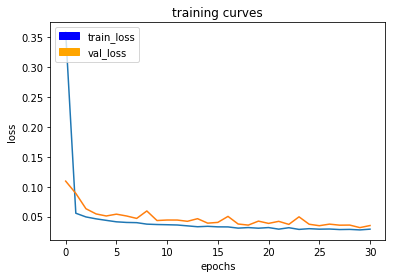

200/200 [==============================] - 850s - loss: 0.0289 - val_loss: 0.0350
Epoch 32/80
199/200 [============================>.] - ETA: 3s - loss: 0.0276

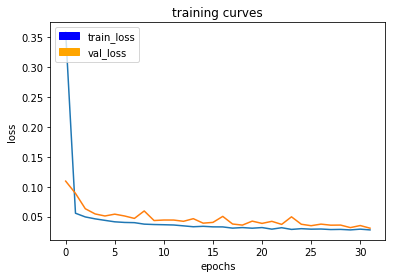

200/200 [==============================] - 851s - loss: 0.0276 - val_loss: 0.0305
Epoch 33/80
199/200 [============================>.] - ETA: 3s - loss: 0.0270

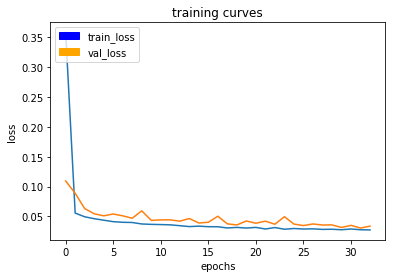

200/200 [==============================] - 852s - loss: 0.0274 - val_loss: 0.0337
Epoch 34/80
199/200 [============================>.] - ETA: 3s - loss: 0.0267

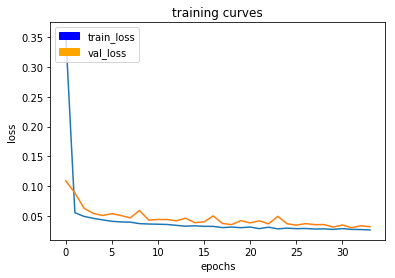

200/200 [==============================] - 851s - loss: 0.0267 - val_loss: 0.0320
Epoch 35/80
199/200 [============================>.] - ETA: 3s - loss: 0.0272

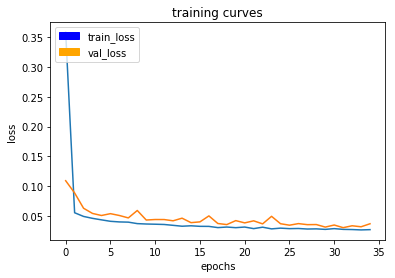

200/200 [==============================] - 852s - loss: 0.0272 - val_loss: 0.0371
Epoch 36/80
199/200 [============================>.] - ETA: 3s - loss: 0.0270

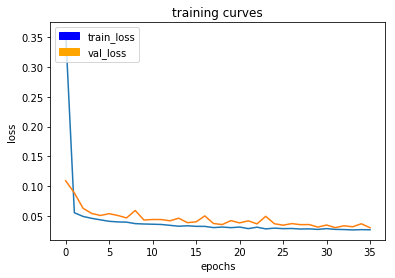

200/200 [==============================] - 851s - loss: 0.0270 - val_loss: 0.0304
Epoch 37/80
199/200 [============================>.] - ETA: 3s - loss: 0.0265

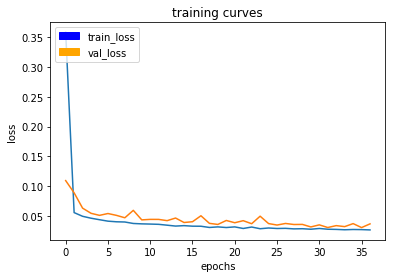

200/200 [==============================] - 849s - loss: 0.0265 - val_loss: 0.0367
Epoch 38/80
199/200 [============================>.] - ETA: 3s - loss: 0.0268

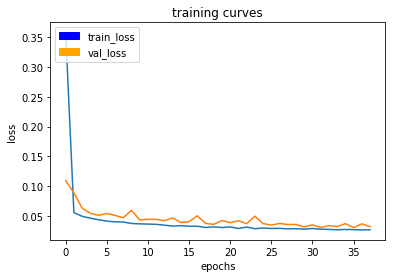

200/200 [==============================] - 849s - loss: 0.0267 - val_loss: 0.0321
Epoch 39/80
199/200 [============================>.] - ETA: 3s - loss: 0.0260

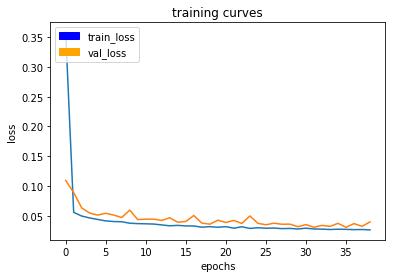

200/200 [==============================] - 850s - loss: 0.0260 - val_loss: 0.0395
Epoch 40/80
199/200 [============================>.] - ETA: 3s - loss: 0.0267

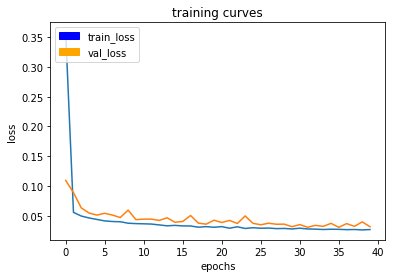

200/200 [==============================] - 851s - loss: 0.0267 - val_loss: 0.0314
Epoch 41/80
199/200 [============================>.] - ETA: 3s - loss: 0.0261

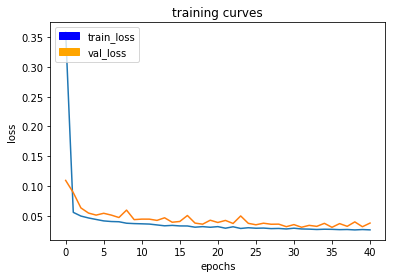

200/200 [==============================] - 849s - loss: 0.0261 - val_loss: 0.0376
Epoch 42/80
199/200 [============================>.] - ETA: 3s - loss: 0.0265

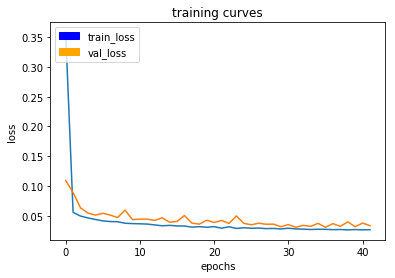

200/200 [==============================] - 851s - loss: 0.0265 - val_loss: 0.0331
Epoch 43/80
199/200 [============================>.] - ETA: 3s - loss: 0.0261

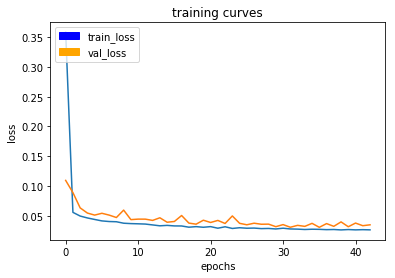

200/200 [==============================] - 851s - loss: 0.0261 - val_loss: 0.0346
Epoch 44/80
199/200 [============================>.] - ETA: 3s - loss: 0.0251

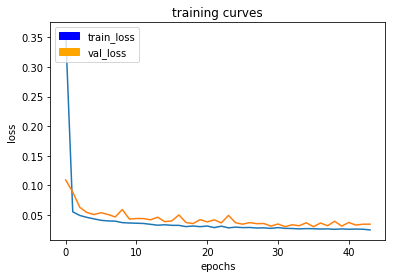

200/200 [==============================] - 852s - loss: 0.0250 - val_loss: 0.0347
Epoch 45/80
199/200 [============================>.] - ETA: 3s - loss: 0.0258

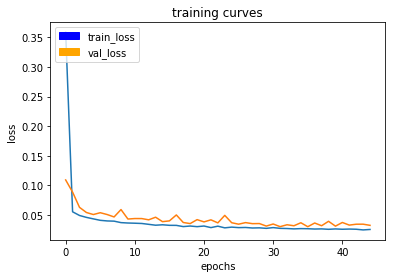

200/200 [==============================] - 851s - loss: 0.0258 - val_loss: 0.0327
Epoch 46/80
199/200 [============================>.] - ETA: 3s - loss: 0.0271

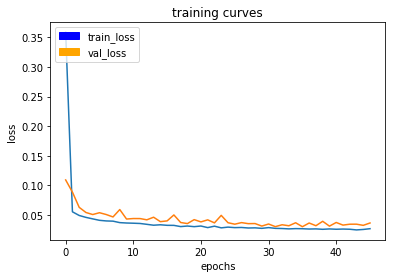

200/200 [==============================] - 850s - loss: 0.0271 - val_loss: 0.0367
Epoch 47/80
199/200 [============================>.] - ETA: 3s - loss: 0.0245

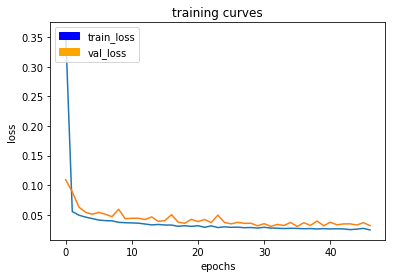

200/200 [==============================] - 847s - loss: 0.0245 - val_loss: 0.0317
Epoch 48/80
199/200 [============================>.] - ETA: 3s - loss: 0.0257

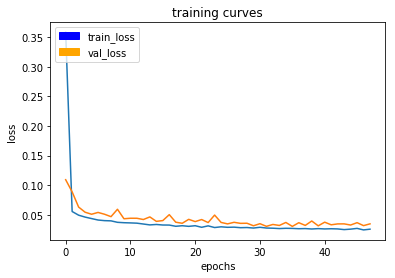

200/200 [==============================] - 848s - loss: 0.0257 - val_loss: 0.0347
Epoch 49/80
199/200 [============================>.] - ETA: 3s - loss: 0.0253

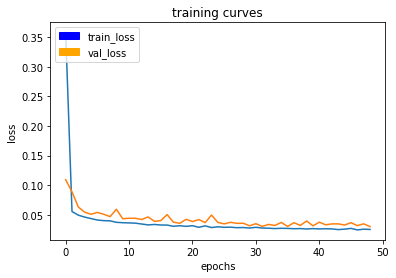

200/200 [==============================] - 848s - loss: 0.0253 - val_loss: 0.0301
Epoch 50/80
199/200 [============================>.] - ETA: 3s - loss: 0.0256

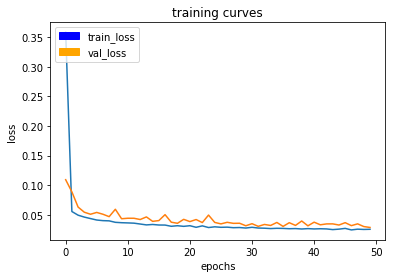

200/200 [==============================] - 849s - loss: 0.0256 - val_loss: 0.0286
Epoch 51/80
199/200 [============================>.] - ETA: 3s - loss: 0.0249

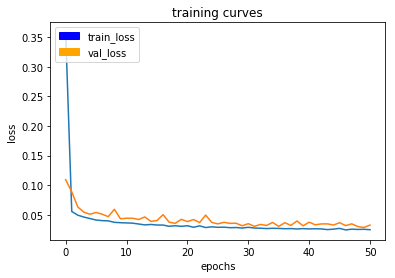

200/200 [==============================] - 849s - loss: 0.0248 - val_loss: 0.0326
Epoch 52/80
199/200 [============================>.] - ETA: 3s - loss: 0.0247

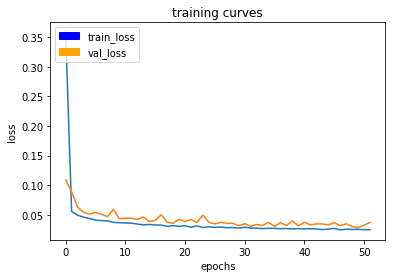

200/200 [==============================] - 847s - loss: 0.0247 - val_loss: 0.0371
Epoch 53/80
199/200 [============================>.] - ETA: 3s - loss: 0.0254

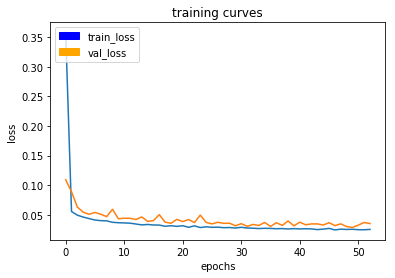

200/200 [==============================] - 850s - loss: 0.0254 - val_loss: 0.0352
Epoch 54/80
199/200 [============================>.] - ETA: 3s - loss: 0.0241

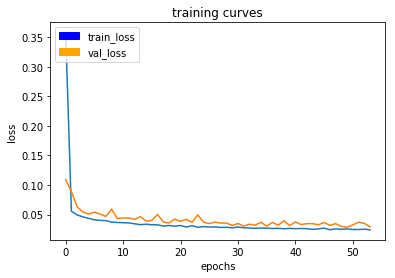

200/200 [==============================] - 849s - loss: 0.0241 - val_loss: 0.0294
Epoch 55/80
199/200 [============================>.] - ETA: 3s - loss: 0.0250

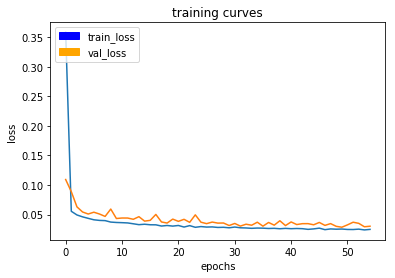

200/200 [==============================] - 850s - loss: 0.0250 - val_loss: 0.0303
Epoch 56/80
199/200 [============================>.] - ETA: 3s - loss: 0.0240

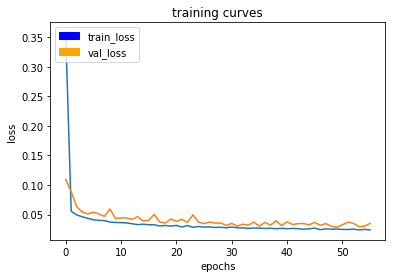

200/200 [==============================] - 849s - loss: 0.0240 - val_loss: 0.0350
Epoch 57/80
199/200 [============================>.] - ETA: 3s - loss: 0.0247

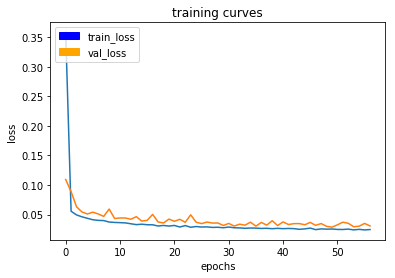

200/200 [==============================] - 850s - loss: 0.0246 - val_loss: 0.0307
Epoch 58/80
199/200 [============================>.] - ETA: 3s - loss: 0.0237

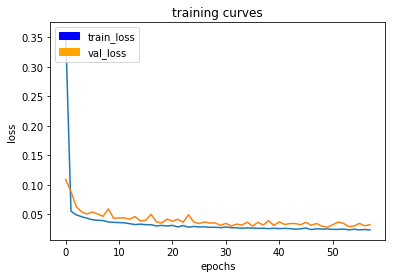

200/200 [==============================] - 851s - loss: 0.0239 - val_loss: 0.0330
Epoch 59/80
199/200 [============================>.] - ETA: 3s - loss: 0.0237

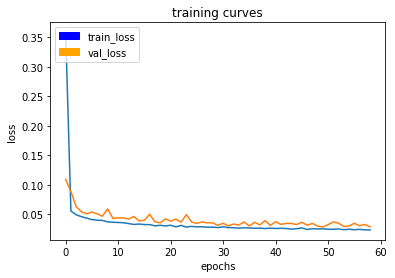

200/200 [==============================] - 853s - loss: 0.0237 - val_loss: 0.0290
Epoch 60/80
199/200 [============================>.] - ETA: 3s - loss: 0.0241

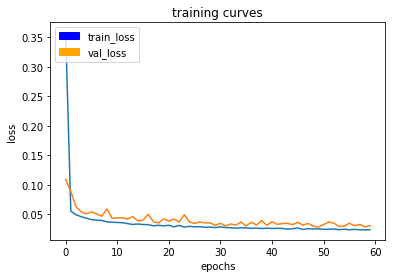

200/200 [==============================] - 851s - loss: 0.0241 - val_loss: 0.0310
Epoch 61/80
199/200 [============================>.] - ETA: 3s - loss: 0.0240

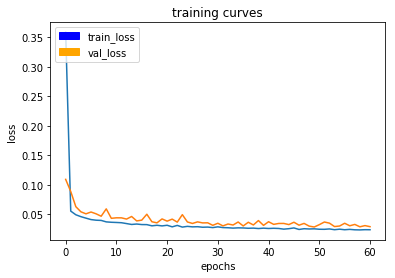

200/200 [==============================] - 850s - loss: 0.0240 - val_loss: 0.0292
Epoch 62/80
199/200 [============================>.] - ETA: 3s - loss: 0.0249

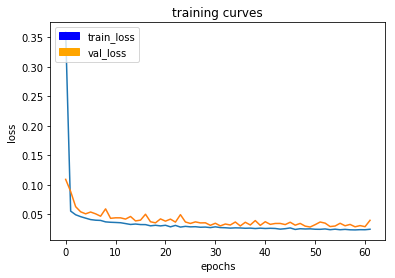

200/200 [==============================] - 852s - loss: 0.0248 - val_loss: 0.0400
Epoch 63/80
199/200 [============================>.] - ETA: 3s - loss: 0.0241

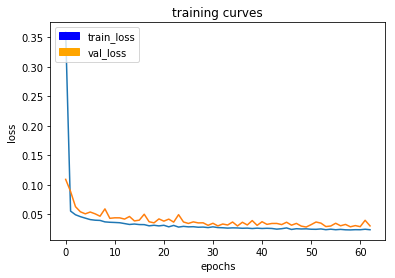

200/200 [==============================] - 851s - loss: 0.0241 - val_loss: 0.0305
Epoch 64/80
199/200 [============================>.] - ETA: 3s - loss: 0.0237

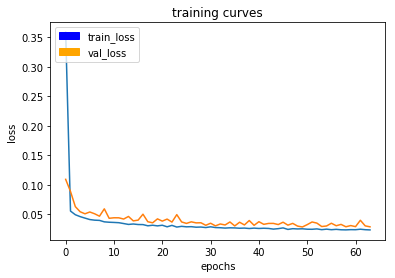

200/200 [==============================] - 851s - loss: 0.0236 - val_loss: 0.0289
Epoch 65/80
199/200 [============================>.] - ETA: 3s - loss: 0.0243

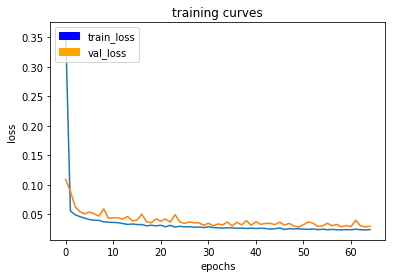

200/200 [==============================] - 850s - loss: 0.0242 - val_loss: 0.0299
Epoch 66/80
199/200 [============================>.] - ETA: 4s - loss: 0.0237

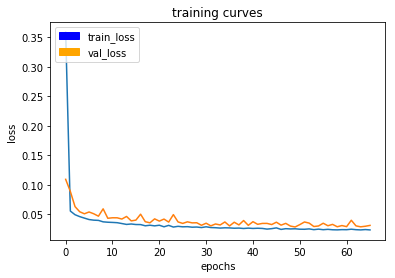

200/200 [==============================] - 859s - loss: 0.0236 - val_loss: 0.0313
Epoch 67/80
199/200 [============================>.] - ETA: 4s - loss: 0.0231

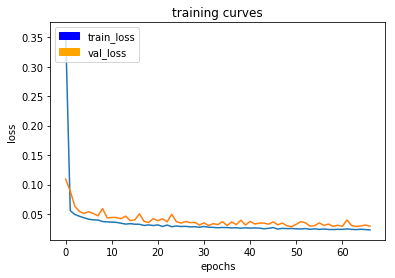

200/200 [==============================] - 854s - loss: 0.0231 - val_loss: 0.0295
Epoch 68/80
199/200 [============================>.] - ETA: 4s - loss: 0.0240

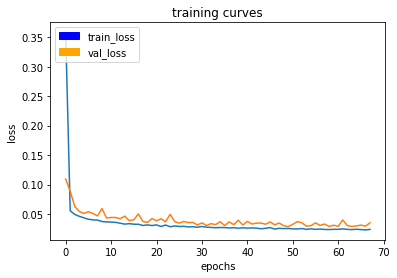

200/200 [==============================] - 856s - loss: 0.0240 - val_loss: 0.0352
Epoch 69/80
199/200 [============================>.] - ETA: 3s - loss: 0.0233

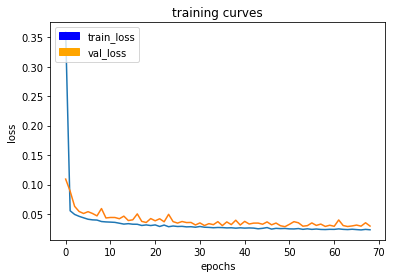

200/200 [==============================] - 853s - loss: 0.0233 - val_loss: 0.0296
Epoch 70/80
199/200 [============================>.] - ETA: 4s - loss: 0.0229

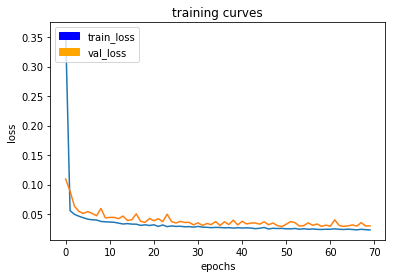

200/200 [==============================] - 855s - loss: 0.0229 - val_loss: 0.0298
Epoch 71/80
199/200 [============================>.] - ETA: 4s - loss: 0.0244

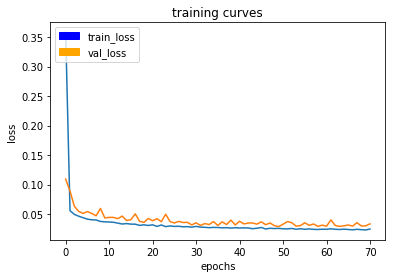

200/200 [==============================] - 855s - loss: 0.0244 - val_loss: 0.0333
Epoch 72/80
199/200 [============================>.] - ETA: 4s - loss: 0.0231

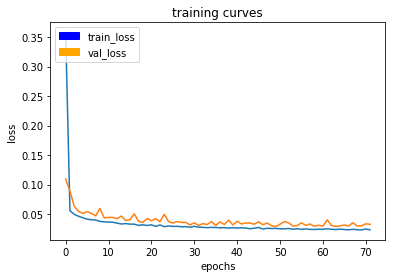

200/200 [==============================] - 853s - loss: 0.0231 - val_loss: 0.0324
Epoch 73/80
199/200 [============================>.] - ETA: 4s - loss: 0.0233

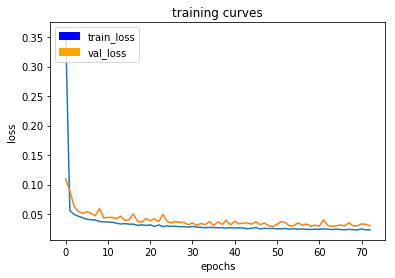

200/200 [==============================] - 854s - loss: 0.0233 - val_loss: 0.0297
Epoch 74/80
199/200 [============================>.] - ETA: 3s - loss: 0.0233

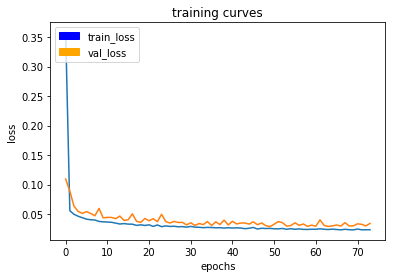

200/200 [==============================] - 853s - loss: 0.0232 - val_loss: 0.0340
Epoch 75/80
199/200 [============================>.] - ETA: 4s - loss: 0.0224

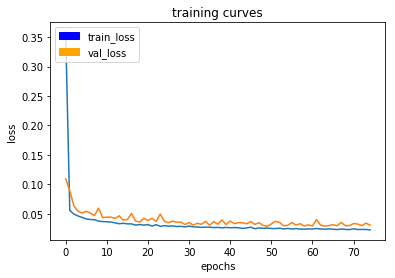

200/200 [==============================] - 860s - loss: 0.0224 - val_loss: 0.0307
Epoch 76/80
199/200 [============================>.] - ETA: 3s - loss: 0.0227

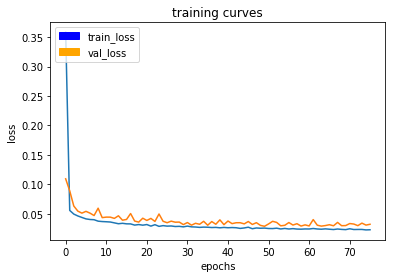

200/200 [==============================] - 852s - loss: 0.0227 - val_loss: 0.0320
Epoch 77/80
199/200 [============================>.] - ETA: 3s - loss: 0.0222

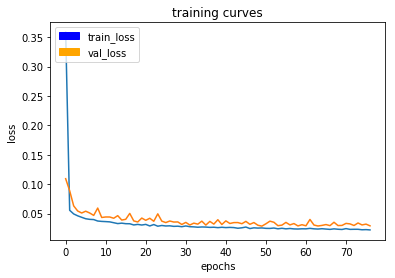

200/200 [==============================] - 852s - loss: 0.0222 - val_loss: 0.0291
Epoch 78/80
199/200 [============================>.] - ETA: 4s - loss: 0.0228

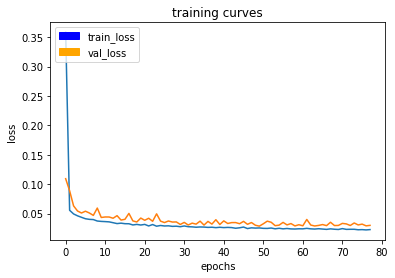

200/200 [==============================] - 854s - loss: 0.0228 - val_loss: 0.0299
Epoch 79/80
199/200 [============================>.] - ETA: 3s - loss: 0.0219

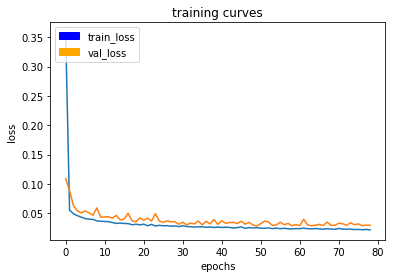

200/200 [==============================] - 851s - loss: 0.0219 - val_loss: 0.0298
Epoch 80/80
199/200 [============================>.] - ETA: 3s - loss: 0.0235

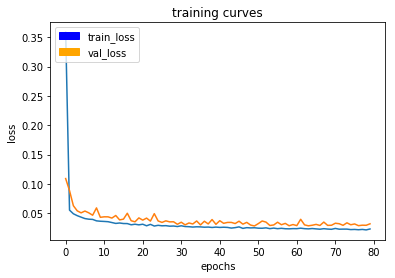

200/200 [==============================] - 851s - loss: 0.0235 - val_loss: 0.0323


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [21]:
# Save your trained model weights
weight_file_name = 'model'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [40]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [11]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

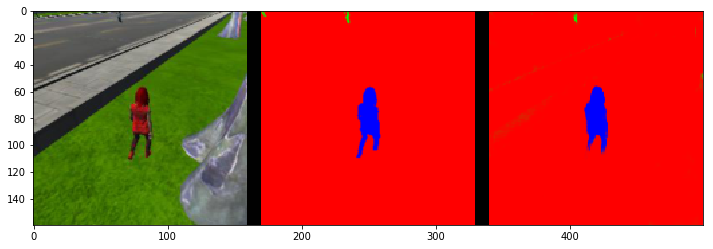

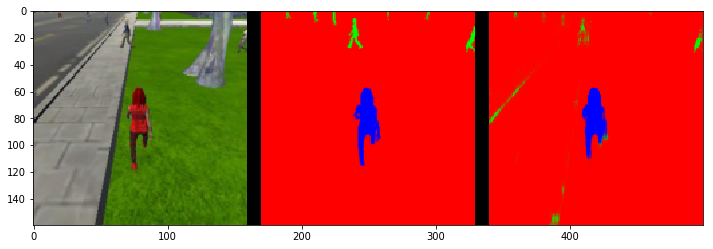

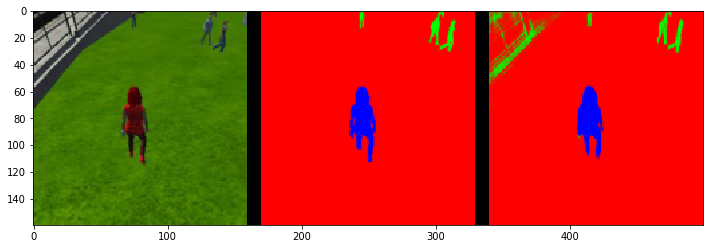

In [12]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

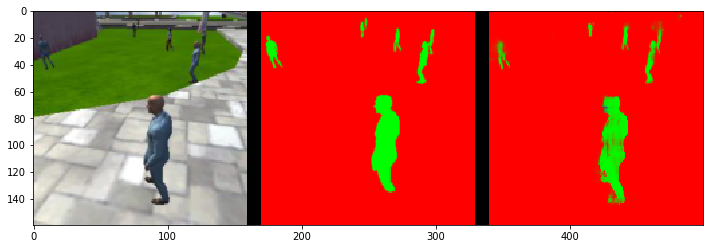

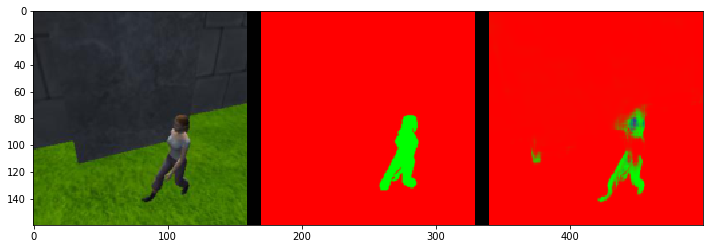

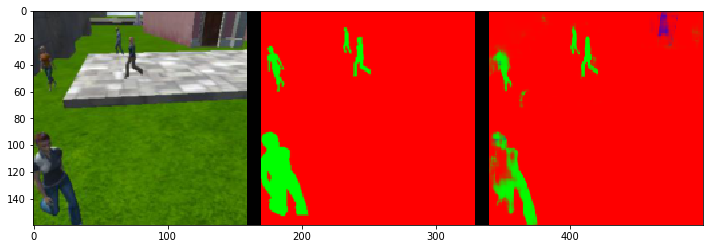

In [13]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

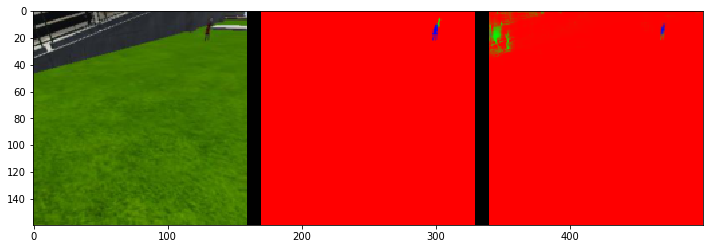

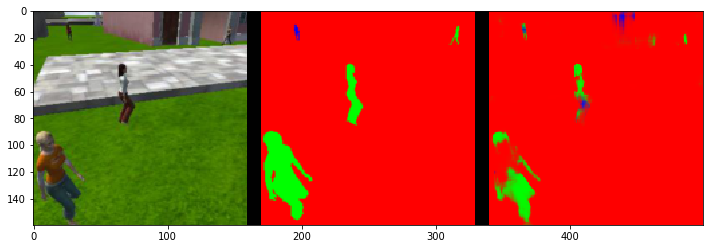

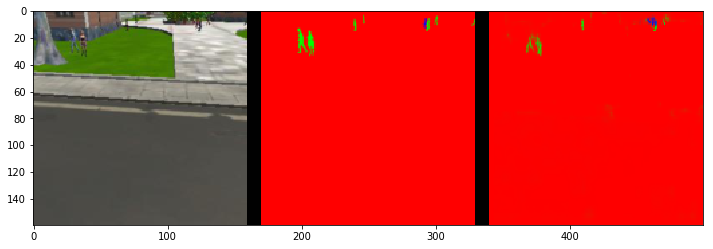

In [14]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [15]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9942986160548879
average intersection over union for other people is 0.311234991463693
average intersection over union for the hero is 0.8952003912410992
number true positives: 539, number false positives: 0, number false negatives: 0


In [16]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.982422687182338
average intersection over union for other people is 0.6190998559534757
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 131, number false negatives: 0


In [17]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.995771059836792
average intersection over union for other people is 0.4158726030812426
average intersection over union for the hero is 0.2470071432451198
number true positives: 166, number false positives: 6, number false negatives: 135


In [18]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.721596724667349


In [19]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.571103767243


In [20]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.412106607888
